# Mapping outliers

This notebook digs more into the outlier areas seen on the added utility maps of England and Wales plotted in the previous notebook.

## Plain English summary

A few areas in England and Wales break the trend shown by the rest. For the treated ischaemic population as a whole, most places show an improvement in added utility in the mothership scenario compared with drip-and-ship. However a few places show a worsening instead.

We will find out more about these outlier areas to see if we can find general trends of when the mothership scenario is a bad idea.

## Aims

+ Find the names of regions that break the trend
+ Look for trends in the treatment times of the outlier regions
+ Use existing generic geography and outcome matrix methods to check that the outlier results make sense.

## Methods

We define outlier regions as any that has better added utility in the drip-and-ship scenario than in mothership.

First we look for other regions that share similar travel times to the outliers.

Then we frame some of the outlier regions in the same context as the generic geography and the outcome matrix results to check what the stroke outcome model has output to create these outliers.

## Import packages

In [1]:
# import contextily as ctx
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import stroke_maps.load_data
import stroke_maps.catchment
import stroke_maps.geo  # to make catchment area geometry

pd.set_option('display.max_rows', 150)

In [2]:
dir_output = 'output'
limit_to_england = False

## Load data

### Load shape file

In [3]:
lsoa_gdf = stroke_maps.load_data.lsoa_geography()
lsoa_gdf = lsoa_gdf.to_crs('EPSG:27700')

lsoa_gdf.head(3)

,OBJECTID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Area,Shape__Length,GlobalID,geometry
0,1,E01000001,City of London 001A,City of London 001A,532129,181625,-0.09706,51.51810,157794.481079,1685.391778,b12173a3-5423-4672-a5eb-f152d2345f96,"POLYGON ((532282.642 181906.500, 532248.262 18..."
1,2,E01000002,City of London 001B,City of London 001B,532480,181699,-0.09197,51.51868,164882.427628,1804.828196,90274dc4-f785-4afb-95cd-7cc1fc9a2cad,"POLYGON ((532746.826 181786.896, 532248.262 18..."
2,3,E01000003,City of London 001C,City of London 001C,532245,182036,-0.09523,51.52176,42219.805717,909.223277,7e89d0ba-f186-45fb-961c-8f5ffcd03808,"POLYGON ((532293.080 182068.426, 532419.605 18..."


In [4]:
# Load country outline
# outline = geopandas.read_file('./data/Countries_(December_2022)_GB_BFC.zip')
if limit_to_england:
    # mask = outline['CTRY22NM'] == 'England'
    # outline = outline[mask]
    outline = stroke_maps.load_data.england_outline()
else:
    # mask = (outline['CTRY22NM'] == 'England') | (outline['CTRY22NM'] == 'Wales')
    # outline = outline[mask]
    outline = stroke_maps.load_data.englandwales_outline()

In [5]:
outline

,country,OBJECTID,ctry11cd,ctry11cdo,ctry11nm,ctry11nmw,GlobalID,geometry
0,0,1,E92000001,921,England,Lloegr,27bbf7ca-99bd-4fe8-87a1-d498d48e3084,"MULTIPOLYGON (((83994.599 5397.099, 84001.300 ..."


### Load hospital info

Load in the stroke unit coordinates and merge in the services information:

In [6]:
df_units = stroke_maps.load_data.stroke_unit_region_lookup()

df_units.head(3).T

postcode,SY231ER,CB20QQ,L97AL
stroke_team,Bronglais Hospital (Aberystwyth),"Addenbrooke's Hospital, Cambridge","University Hospital Aintree, Liverpool"
short_code,AB,AD,AI
ssnap_name,Bronglais Hospital,Addenbrooke's Hospital,University Hospital Aintree
use_ivt,1,1,1
use_mt,0,1,1
use_msu,0,1,1
transfer_unit_postcode,nearest,nearest,nearest
lsoa,Ceredigion 002A,Cambridge 013D,Liverpool 005A
lsoa_code,W01000512,E01017995,E01006654
region,Hywel Dda University Health Board,NHS Cambridgeshire and Peterborough ICB - 06H,NHS Cheshire and Merseyside ICB - 99A


In [7]:
hospitals_gdf = stroke_maps.load_data.stroke_unit_coordinates()
hospitals_gdf = pd.merge(
    hospitals_gdf, df_units[['use_ivt', 'use_mt']],
    left_index=True, right_index=True, how='right'
)

In [8]:
hospitals_gdf.head(3)

,BNG_E,BNG_N,Latitude,Longitude,geometry,use_ivt,use_mt
postcode,,,,,,,
SY231ER,259208,281805,52.416068,-4.071578,POINT (259208.000 281805.000),1,0
CB20QQ,546375,254988,52.173741,0.139114,POINT (546375.000 254988.000),1,1
L97AL,338020,397205,53.467918,-2.935131,POINT (338020.000 397205.000),1,1


### Load LSOA model output data

In [9]:
lsoa_data = pd.read_csv(os.path.join(dir_output, 'cohort_outcomes_weighted.csv'))
lsoa_data.head(3).T

,0,1,2
lsoa,Adur 001A,Adur 001B,Adur 001C
closest_ivt_time,17.6,18.7,17.6
closest_ivt_unit,BN25BE,BN25BE,BN112DH
closest_mt_time,17.6,18.7,19.8
closest_mt_unit,BN25BE,BN25BE,BN25BE
transfer_mt_time,0.0,0.0,31.6
transfer_mt_unit,BN25BE,BN25BE,BN25BE
mt_transfer_required,False,False,True
ivt_drip_ship,107.6,108.7,107.6
mt_drip_ship,167.6,168.7,259.2


In [10]:
# Merge with shape file

lsoa_data_gdf = lsoa_gdf.merge(lsoa_data, left_on='LSOA11NM', right_on='lsoa', how='right')
lsoa_data_gdf.head()

,OBJECTID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Area,Shape__Length,...,mothership_weighted_mrs_shift,mothership_weighted_added_mrs_less_equal_2,drip_ship_weighted_treated_added_utility,drip_ship_weighted_treated_mrs_less_equal_2,drip_ship_weighted_treated_mrs_shift,drip_ship_weighted_treated_added_mrs_less_equal_2,mothership_weighted_treated_added_utility,mothership_weighted_treated_mrs_less_equal_2,mothership_weighted_treated_mrs_shift,mothership_weighted_treated_added_mrs_less_equal_2
0,30557.0,E01031349,Adur 001A,Adur 001A,524915.0,105607.0,-0.22737,50.83651,3.641032e+05,3054.751704,...,-0.17815,0.03626,0.13633,0.56689,-0.71592,0.14571,0.13633,0.56689,-0.71592,0.14571
1,30558.0,E01031350,Adur 001B,Adur 001B,524825.0,106265.0,-0.22842,50.84244,2.921732e+05,2977.102897,...,-0.17740,0.03611,0.13579,0.56630,-0.71290,0.14512,0.13579,0.56630,-0.71290,0.14512
2,30559.0,E01031351,Adur 001C,Adur 001C,523053.0,108004.0,-0.25300,50.85845,5.281768e+06,11671.349143,...,-0.17665,0.03597,0.11106,0.53979,-0.58086,0.11861,0.13525,0.56571,-0.70988,0.14453
3,30560.0,E01031352,Adur 001D,Adur 001D,524141.0,106299.0,-0.23812,50.84290,2.452292e+05,2134.908586,...,-0.17665,0.03597,0.11106,0.53979,-0.58086,0.11861,0.13525,0.56571,-0.70988,0.14453
4,30578.0,E01031370,Adur 001E,Adur 001E,523561.0,105916.0,-0.24649,50.83958,2.402445e+05,2447.096939,...,-0.17665,0.03597,0.11159,0.54036,-0.58379,0.11918,0.13525,0.56571,-0.70988,0.14453


In [11]:
cols = [c for c in lsoa_data_gdf.columns if (('lvo' in c) & ('nlvo' not in c) & ('utility' in c))]

lsoa_data_gdf[cols].head(10).T

,0,1,2,3,4,5,6,7,8,9
drip_ship_lvo_ivt_added_utility,0.05872,0.05841,0.05872,0.05872,0.05902,0.05872,0.05872,0.05872,0.05872,0.05872
drip_ship_lvo_ivt_mt_added_utility,0.16361,0.16295,0.10928,0.10928,0.10992,0.10928,0.10928,0.10928,0.10928,0.10928
drip_ship_lvo_mt_added_utility,0.16361,0.16295,0.10928,0.10928,0.10992,0.10928,0.10928,0.10928,0.10928,0.10928
mothership_lvo_ivt_added_utility,0.05872,0.05841,0.05811,0.05811,0.05811,0.05841,0.05783,0.05752,0.05752,0.05752
mothership_lvo_ivt_mt_added_utility,0.16361,0.16295,0.16229,0.16229,0.16229,0.16295,0.16169,0.16103,0.16103,0.16103
mothership_lvo_mt_added_utility,0.16361,0.16295,0.16229,0.16229,0.16229,0.16295,0.16169,0.16103,0.16103,0.16103
drip_ship_lvo_mix_added_utility,0.15548,0.15485,0.10536,0.10536,0.10598,0.10536,0.10536,0.10536,0.10536,0.10536
mothership_lvo_mix_added_utility,0.15548,0.15485,0.15422,0.15422,0.15422,0.15485,0.15364,0.15301,0.15301,0.15301


Patient proportions:

In [12]:
patient_proportions = pd.read_csv(
    os.path.join('..', 'england_wales', 'output', 'patient_proportions.csv'),
    index_col=0, header=None).squeeze()

In [13]:
patient_proportions

0
haemorrhagic         0.13600
lvo_no_treatment     0.14648
lvo_ivt_only         0.00840
lvo_ivt_mt           0.08500
lvo_mt_only          0.01500
nlvo_no_treatment    0.50252
nlvo_ivt             0.10660
Name: 1, dtype: float64

In [14]:
# Proportion of treated ischaemic patients:
prop_ischaemic_treated = 0.0

for key, value in patient_proportions.items():
    if (('lvo' in key) & ('no_treat' not in key)):
        print(key)
        prop_ischaemic_treated += value

prop_ischaemic_treated

lvo_ivt_only
lvo_ivt_mt
lvo_mt_only
nlvo_ivt


0.21500000000000002

In [15]:
prop_nlvo_of_treated = patient_proportions['nlvo_ivt'] / prop_ischaemic_treated
prop_lvo_of_treated = 1.0 - prop_nlvo_of_treated

prop_nlvo_of_treated, prop_lvo_of_treated

(0.49581395348837204, 0.5041860465116279)

## Calculate difference between Mothership and Drip and Ship

In [16]:
cohort_names = ['nlvo_ivt', 'lvo_mix', 'weighted_treated']

outcome_names = ['added_utility', 'added_mrs_less_equal_2', 'mrs_shift']

In [17]:
cols_diff = [f'{c}_{o}_mothership_minus_dripship' for c in cohort_names for o in outcome_names]
cols_moth = [f'mothership_{c}_{o}' for c in cohort_names for o in outcome_names]
cols_drip = [f'drip_ship_{c}_{o}' for c in cohort_names for o in outcome_names]

lsoa_data_gdf[cols_diff] = lsoa_data_gdf[cols_moth].values - lsoa_data_gdf[cols_drip].values

## Map outliers

Make a new dataframe with only a subset of the full data:

In [18]:
data_field = 'added_utility'

cols = [
    f'nlvo_ivt_{data_field}_mothership_minus_dripship',
    f'lvo_mix_{data_field}_mothership_minus_dripship',
    f'weighted_treated_{data_field}_mothership_minus_dripship',
]

In [19]:
gdf_outliers = lsoa_data_gdf[['geometry'] + cols]

Find outliers separately for each case because the outlying condition is different each time.

For nLVO, most of the map has negative mothership minus drip-and-ship added utility, so pick out values that are positive.

For the LVO and ischaemic mix, most of the map is positive so pick out any negative values.

In [20]:
col = cols[0]
gdf_outliers[f'outlier_{col}'] = gdf_outliers[col] > 0.0

# How many values are outliers?
print(len(gdf_outliers.loc[gdf_outliers[f'outlier_{col}'] == True]))

0


/home/anna/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [21]:
col = cols[1]
gdf_outliers[f'outlier_{col}'] = gdf_outliers[col] < 0.0

# How many values are outliers?
print(len(gdf_outliers.loc[gdf_outliers[f'outlier_{col}'] == True]))

0


/home/anna/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [22]:
col = cols[2]
gdf_outliers[f'outlier_{col}'] = gdf_outliers[col] < 0.0

# How many values are outliers?
print(len(gdf_outliers.loc[gdf_outliers[f'outlier_{col}'] == True]))

266


/home/anna/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Only the mixed population has outliers. Plot their locations:

266


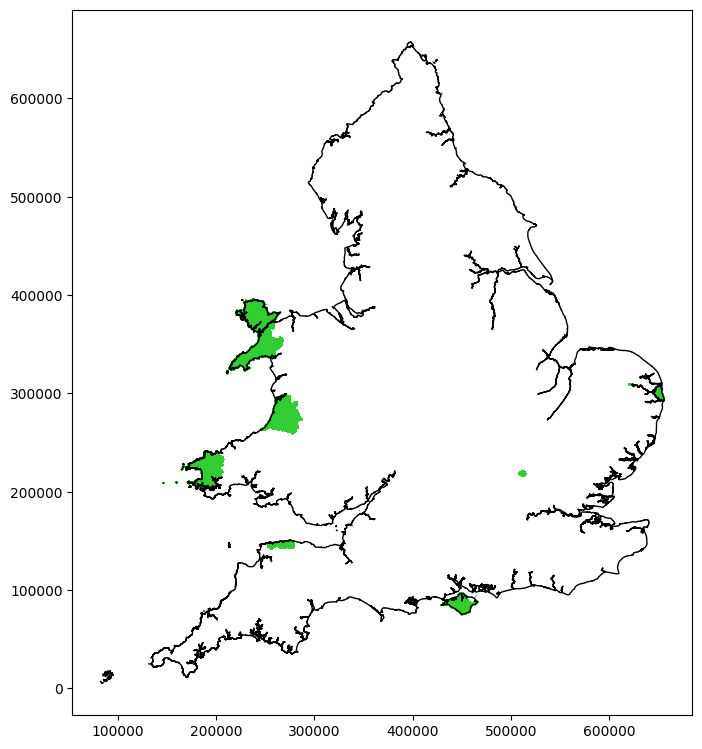

In [23]:
col = cols[2]

# Plot data
fig, ax = plt.subplots(figsize=(8, 10))
mask = gdf_outliers[f'outlier_{col}'] == True
print(len(gdf_outliers.loc[mask]))
gdf_outliers.loc[mask].plot(
    ax=ax, # Set which axes to use for plot (only one here)
    color='LimeGreen', # Column to apply colour
    antialiased=False, # Avoids artifact boundry lines
    edgecolor='face', # Make LSOA boundry same colour as area
)
# Add country border
outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)
plt.show()

## Check outlier times

Make a smaller dataframe of all of the columns for just these outlier areas:

In [24]:
col = cols[2]

mask = gdf_outliers[f'outlier_{col}'] == True

gdf_out_adv = lsoa_data_gdf.loc[mask].copy()

In [25]:
gdf_out_adv

,OBJECTID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Area,Shape__Length,...,mothership_weighted_treated_added_mrs_less_equal_2,nlvo_ivt_added_utility_mothership_minus_dripship,nlvo_ivt_added_mrs_less_equal_2_mothership_minus_dripship,nlvo_ivt_mrs_shift_mothership_minus_dripship,lvo_mix_added_utility_mothership_minus_dripship,lvo_mix_added_mrs_less_equal_2_mothership_minus_dripship,lvo_mix_mrs_shift_mothership_minus_dripship,weighted_treated_added_utility_mothership_minus_dripship,weighted_treated_added_mrs_less_equal_2_mothership_minus_dripship,weighted_treated_mrs_shift_mothership_minus_dripship
6195,17053.0,E01017564,Central Bedfordshire 033D,Central Bedfordshire 033D,511088.0,218265.0,-0.388520,51.85194,1.794032e+07,20786.770830,...,0.10599,-0.02931,-0.03210,0.16838,0.01779,0.01888,-0.09336,-0.00556,-0.00640,0.03641
6196,33344.0,W01000523,Ceredigion 001C,Ceredigion 001C,268865.0,290703.0,-3.933180,52.49843,1.294319e+08,55283.856672,...,0.08350,-0.04997,-0.05460,0.28511,0.03201,0.03184,-0.15103,-0.00863,-0.01102,0.06522
6197,33367.0,W01000548,Ceredigion 001D,Ceredigion 001D,261295.0,285094.0,-4.042280,52.44616,1.452597e+07,21925.550573,...,0.08350,-0.05255,-0.05744,0.30018,0.02998,0.02971,-0.14004,-0.01094,-0.01350,0.07823
6198,33368.0,W01000549,Ceredigion 001E,Ceredigion 001E,267387.0,283780.0,-3.952180,52.43587,2.582152e+07,27673.339921,...,0.08291,-0.05220,-0.05705,0.29800,0.03004,0.02977,-0.14047,-0.01074,-0.01328,0.07694
6199,34732.0,W01001937,Ceredigion 001F,Ceredigion 001F,261990.0,288178.0,-4.033340,52.47405,2.536853e+07,28049.044543,...,0.08291,-0.04958,-0.05416,0.28268,0.03210,0.03192,-0.15161,-0.00840,-0.01076,0.06372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32026,29482.0,E01030263,Waveney 005B,Waveney 005B,653306.0,293630.0,1.729125,52.48177,7.875654e+05,3912.339748,...,0.09557,-0.04037,-0.04419,0.23137,0.03527,0.03697,-0.18337,-0.00224,-0.00327,0.02227
32027,29489.0,E01030270,Waveney 005C,Waveney 005C,652508.0,293295.0,1.717146,52.47913,5.150318e+05,3402.978540,...,0.09676,-0.03940,-0.04313,0.22592,0.03649,0.03829,-0.18986,-0.00114,-0.00208,0.01629
32032,29487.0,E01030268,Waveney 006C,Waveney 006C,651334.0,293510.0,1.700058,52.48160,3.534155e+05,4242.495260,...,0.09557,-0.03997,-0.04374,0.22901,0.03581,0.03754,-0.18620,-0.00177,-0.00276,0.01967
32033,29488.0,E01030269,Waveney 006D,Waveney 006D,651416.0,293083.0,1.700941,52.47773,8.158435e+05,4654.804663,...,0.09616,-0.03904,-0.04272,0.22370,0.03702,0.03882,-0.19255,-0.00069,-0.00161,0.01383


Pick out the first part of the LSOA names to get an idea of their towns or regions:

In [26]:
sorted(list(set([s[:-5] for s in gdf_out_adv['LSOA11NM'].values])))

['Central Bedfordshire',
 'Ceredigion',
 'Great Yarmouth',
 'Gwynedd',
 'Isle of Anglesey',
 'Isle of Wight',
 'North Devon',
 'Norwich',
 'Pembrokeshire',
 'Waveney']

Eyeball the travel and treatment time columns:

In [27]:
cols_to_check = [
    'LSOA11NM',
    'closest_ivt_time',
    'closest_ivt_unit',
    'closest_mt_time',
    'closest_mt_unit',
    'transfer_mt_time',
    'transfer_mt_unit',
    'mt_transfer_required',
    'ivt_drip_ship',
    'mt_drip_ship',
    'ivt_mothership',
    'mt_mothership'
]


In [28]:
gdf_out_adv[cols_to_check].T

,6195,6196,6197,6198,6199,6200,6201,6202,6203,6204,...,32021,32022,32023,32024,32025,32026,32027,32032,32033,32035
LSOA11NM,Central Bedfordshire 033D,Ceredigion 001C,Ceredigion 001D,Ceredigion 001E,Ceredigion 001F,Ceredigion 002A,Ceredigion 002B,Ceredigion 002D,Ceredigion 002F,Ceredigion 003A,...,Waveney 004C,Waveney 004D,Waveney 004E,Waveney 004F,Waveney 005A,Waveney 005B,Waveney 005C,Waveney 006C,Waveney 006D,Waveney 007A
closest_ivt_time,21.9,16.5,10.1,12.2,18.7,6.9,6.9,7.9,6.9,9.0,...,17.6,17.6,16.5,17.6,18.7,15.5,15.5,16.5,17.6,16.5
closest_ivt_unit,LU40DZ,SY231ER,SY231ER,SY231ER,SY231ER,SY231ER,SY231ER,SY231ER,SY231ER,SY231ER,...,NR316LA,NR316LA,NR316LA,NR316LA,NR316LA,NR316LA,NR316LA,NR316LA,NR316LA,NR316LA
closest_mt_time,91.7,133.6,133.6,134.7,134.7,134.7,135.8,136.8,134.7,136.8,...,111.1,111.1,112.1,111.1,110.0,111.1,108.9,111.1,110.0,111.1
closest_mt_unit,NW12BU,ST46QG,CF144XW,CF144XW,ST46QG,CF144XW,CF144XW,CF144XW,CF144XW,CF144XW,...,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ
transfer_mt_time,45.5,135.8,135.8,135.8,135.8,135.8,135.8,135.8,135.8,135.8,...,105.7,105.7,105.7,105.7,105.7,105.7,105.7,105.7,105.7,105.7
transfer_mt_unit,NW12BU,CF144XW,CF144XW,CF144XW,CF144XW,CF144XW,CF144XW,CF144XW,CF144XW,CF144XW,...,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ
mt_transfer_required,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
ivt_drip_ship,111.9,106.5,100.1,102.2,108.7,96.9,96.9,97.9,96.9,99.0,...,107.6,107.6,106.5,107.6,108.7,105.5,105.5,106.5,107.6,106.5
mt_drip_ship,277.4,362.3,355.9,358.0,364.5,352.7,352.7,353.7,352.7,354.8,...,333.3,333.3,332.2,333.3,334.4,331.2,331.2,332.2,333.3,332.2


Find the difference in travel times between LSOA to MT unit and LSOA to IVT unit.

In [29]:
gdf_out_adv['unit_time_diff'] = gdf_out_adv['closest_mt_time'] - gdf_out_adv['closest_ivt_time']

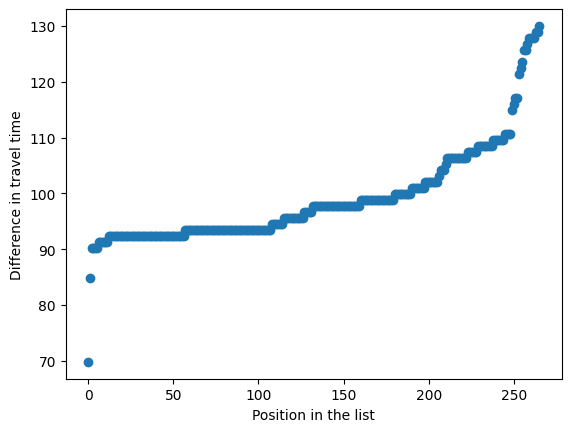

In [30]:
plt.scatter(np.arange(len(gdf_out_adv)), sorted(gdf_out_adv['unit_time_diff']))
plt.xlabel('Position in the list')
plt.ylabel('Difference in travel time')
plt.show()

Eyeballing this, nearly all of the outliers have a difference in time of at least 90 minutes or an hour and a half.

The shortest time is for Central Bedfordshire, which is anomalous in the travel times matrix because none of its surrounding LSOAs have similar travel times. This LSOA has a longer time direct to the MT unit (91.7 mins) than the sum of the travel time to the IVT unit and then transfer to the MT unit (21.9 + 45.5 = 67.4 mins).

Find the shortest time excluding that LSOA:

In [31]:
mask_bed = gdf_out_adv['LSOA11NM'].str.contains('Bedfordshire')

In [32]:
gdf_out_adv.loc[~mask_bed, 'unit_time_diff'].min()

84.80000000000001

## Pick out LSOAs similar to the outliers

Find if there are other LSOAs in the full dataframe that are not flagged as outliers but have a similar difference in unit travel times.

In [33]:
lsoa_data_gdf['unit_time_diff'] = lsoa_data_gdf['closest_mt_time'] - lsoa_data_gdf['closest_ivt_time']

In [34]:
mask_time = lsoa_data_gdf['unit_time_diff'] >= 84.8

In [35]:
len(lsoa_data_gdf.loc[mask_time])

359

There are more LSOAs in this list than there were in the outliers list.

Plot the new flagged LSOAs next to the marked outliers:

266


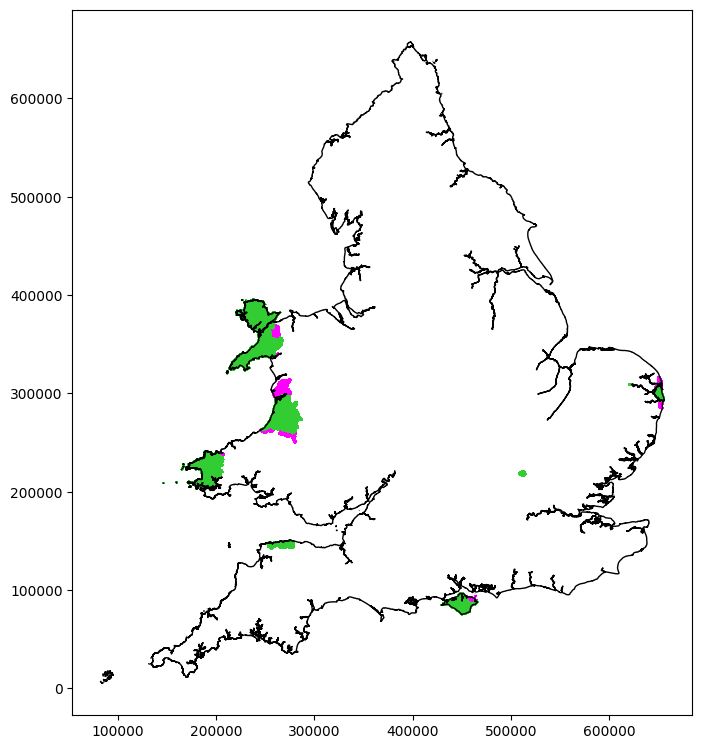

In [36]:
# Plot data
fig, ax = plt.subplots(figsize=(8, 10))

lsoa_data_gdf.loc[mask_time].plot(
    ax=ax, # Set which axes to use for plot (only one here)
    color='magenta',
    antialiased=False, # Avoids artifact boundry lines
    edgecolor='face', # Make LSOA boundry same colour as area
)

mask = gdf_outliers[f'outlier_{col}'] == True
print(len(gdf_outliers.loc[mask]))
gdf_outliers.loc[mask].plot(
    ax=ax, # Set which axes to use for plot (only one here)
    color='LimeGreen',
    antialiased=False, # Avoids artifact boundry lines
    edgecolor='face', # Make LSOA boundry same colour as area
)

# Add country border
outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)
plt.show()

## Generic geography

Show two cases with the same circle plots as used in the generic geography example. The first case is the stroke units whose outliers have the smallest time difference between hospitals. The second case is the same for the biggest time difference.

In [37]:
# Take the mean of all values in the outlier dataframe grouped by closest IVT unit:
gdf_out_adv_mean = gdf_out_adv.groupby('closest_ivt_unit').mean(numeric_only=True)

# Only keep columns involving times:
gdf_out_adv_mean = gdf_out_adv_mean[
    [t for t in gdf_out_adv.columns if (
        ('time' in t) | (t.endswith('drip_ship')) | (t.endswith('mothership'))
    )]
]
# Sort by increasing time difference:
gdf_out_adv_mean = gdf_out_adv_mean.sort_values('unit_time_diff')

# Merge in stroke unit names:
gdf_out_adv_mean = pd.merge(
    gdf_out_adv_mean, df_units[['stroke_team', 'region']],
    left_index=True, right_index=True, how='left'
)

gdf_out_adv_mean

,closest_ivt_time,closest_mt_time,transfer_mt_time,ivt_drip_ship,mt_drip_ship,ivt_mothership,mt_mothership,unit_time_diff,stroke_team,region
closest_ivt_unit,,,,,,,,,,
LU40DZ,21.900000,91.700000,45.5,111.900000,277.400000,181.700000,241.700000,69.800000,Luton and Dunstable Hospital,"NHS Bedfordshire, Luton and Milton Keynes ICB ..."
EX314JB,25.580000,117.720000,90.6,115.580000,326.180000,207.720000,267.720000,92.140000,"North Devon District Hospital, Barnstaple",NHS Devon ICB - 15N
LL572PW,25.594118,118.407059,103.5,115.594118,339.094118,208.407059,268.407059,92.812941,Ysbyty Gwynedd (Bangor),Betsi Cadwaladr University Health Board
NR316LA,13.147170,108.401887,105.7,103.147170,328.847170,198.401887,258.401887,95.254717,"James Paget Hospitals, Great Yarmouth",NHS Norfolk and Waveney ICB - 26A
SA612PZ,18.102857,116.385714,107.8,108.102857,335.902857,206.385714,266.385714,98.282857,Withybush General Hospital (Haverfordwest),Hywel Dda University Health Board
PO305TG,17.898485,122.633333,117.5,107.898485,345.398485,212.633333,272.633333,104.734848,"St Mary's Hospital, Newport",NHS Hampshire and Isle of Wight ICB - D9Y0V
NR47UY,12.200000,121.800000,78.8,102.200000,301.000000,211.800000,271.800000,109.600000,Norfolk and Norwich University Hospital,NHS Norfolk and Waveney ICB - 26A
SY231ER,12.985000,133.985000,135.8,102.985000,358.785000,223.985000,283.985000,121.000000,Bronglais Hospital (Aberystwyth),Hywel Dda University Health Board


The shortest time difference*: stroke unit EX31 4JB, North Devon District Hospital, Barnstaple.  
The largest time difference: stroke unit SY23 1ER, Bronglais Hospital (Aberystwyth).

\* excluding Central Bedfordshire with closest unit LU4 0DZ, where the times look a bit dodgy. The times are also fishy for Norwich - the combined travel to IVT and then MT unit is less than going directly to an MT unit.

### Setup for outcomes

In [38]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [39]:
import sys

sys.path.insert(0, '../general_results')

from geography_calc import main

In [40]:
fixed_times = pd.read_csv(
        os.path.join('..', 'england_wales', 'output', 'pathway_times.csv'),
        index_col=0, header=None).squeeze()

In [41]:
patient_proportions = pd.read_csv(
    os.path.join('..', 'england_wales', 'output', 'patient_proportions.csv'),
    index_col=0, header=None).squeeze()

In [42]:
patient_proportions

0
haemorrhagic         0.13600
lvo_no_treatment     0.14648
lvo_ivt_only         0.00840
lvo_ivt_mt           0.08500
lvo_mt_only          0.01500
nlvo_no_treatment    0.50252
nlvo_ivt             0.10660
Name: 1, dtype: float64

### Example 1:

Calculate coordinates of an outlier patient:

In [43]:
gdf_patient = gdf_out_adv.loc[gdf_out_adv['closest_ivt_unit'] == 'EX314JB'].iloc[0]

In [44]:
time_to_ivt = gdf_patient['closest_ivt_time']
time_to_mt = gdf_patient['closest_mt_time']
time_transfer = gdf_patient['transfer_mt_time']

# Cosine rule:
ang = np.arccos(
    (time_to_ivt**2.0 + time_transfer**2.0 - time_to_mt**2.0) /
    (2 * time_to_ivt * time_transfer)        
    )

# Coordinates relative to IVT unit (sohcahtoa):
patient_x = time_to_ivt * np.sin(np.pi - ang)
patient_y = time_to_ivt * np.cos(np.pi - ang)

(patient_x, patient_y)

(17.13915576825811, 16.942825607064037)

In [46]:
# Add an extra fixed time that is specific to this generic geography example.
fixed_times['travel_ivt_to_mt'] = time_transfer
fixed_times['ivt_x'] = 0
fixed_times['ivt_y'] = 0
fixed_times['mt_x'] = 0
fixed_times['mt_y'] = -fixed_times['travel_ivt_to_mt']

# Calculate the fixed times to treatment _excluding_ the travel from the patient location to the first stroke unit.

# Times for usual care (the patient goes to their nearest stroke unit and is later transferred to the MT unit if necessary):

fixed_times['usual_care_ivt'] = (
    fixed_times['onset_to_ambulance_arrival'] + 
    fixed_times['arrival_to_ivt']
    )

fixed_times['usual_care_mt'] = (
    fixed_times['onset_to_ambulance_arrival'] + 
    # fixed_times['arrival_to_ivt'] + 
    fixed_times['net_operational_delay_to_mt_for_transfer'] + 
    fixed_times['travel_ivt_to_mt'] + 
    fixed_times['arrival_to_mt']
    )

# Times for mothership (the patient goes directly to the MT unit):

fixed_times['mothership_ivt'] = (
    fixed_times['onset_to_ambulance_arrival'] + 
    fixed_times['arrival_to_ivt']
    )

fixed_times['mothership_mt'] = (
    fixed_times['onset_to_ambulance_arrival'] + 
    fixed_times['arrival_to_mt']
    )

In [48]:
dict_grid_time_travel, dict_grid_time_travel_info, dict_outcomes_dicts = (
    main(fixed_times, patient_proportions))

In [64]:
def plot_geography_outliers(dict_grid_time_travel, dict_grid_time_travel_info, dict_outcomes_dicts, patient_x, patient_y):
    # Shared grid extents:
    extent = [
        -dict_grid_time_travel_info['diff']['mothership_grid_xy_max'],
        dict_grid_time_travel_info['diff']['mothership_grid_xy_max'],
        -dict_grid_time_travel_info['diff']['mothership_grid_xy_max'],
        dict_grid_time_travel_info['diff']['mothership_grid_xy_max'],
    ]
    
    # Shared colour limits:
    vmin = min([
        dict_outcomes_dicts['diff']['nlvo_ivt']['added_utility'].min(),
        dict_outcomes_dicts['diff']['lvo']['added_utility'].min(),
        dict_outcomes_dicts['diff']['mixed']['added_utility'].min(),
    ])
    vmax = max([
        dict_outcomes_dicts['diff']['nlvo_ivt']['added_utility'].max(),
        dict_outcomes_dicts['diff']['lvo']['added_utility'].max(),
        dict_outcomes_dicts['diff']['mixed']['added_utility'].max(),
    ])
    vlim = max([abs(vmin), abs(vmax)])
    vmin = -vlim
    vmax = vlim
    
    contour_levels = np.linspace(vmin, vmax, 9)
    
    cmap = 'bwr'
    
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    
    ax_time = axs[0]
    ax_nlvo = axs[1]
    ax_lvo = axs[2]
    ax_mix = axs[3]
    
    s = dict_grid_time_travel['diff'].shape
    
    t = ax_time.imshow(
        -dict_grid_time_travel['diff'],
        extent=extent,
        origin='lower'
    )
    plt.colorbar(t, orientation='horizontal', label='Travel time difference')
    
    grid = dict_outcomes_dicts['diff']['nlvo_ivt']['added_utility'].values.reshape(s)
    t = ax_nlvo.imshow(
        grid,
        extent=extent,
        origin='lower',
        vmin=vmin,
        vmax=vmax,
        cmap=cmap
    )
    plt.colorbar(t, orientation='horizontal', label='Added utility\n(advantage of mothership)')
    CS = ax_nlvo.contour(
        grid,
        extent=extent,
        levels=contour_levels,
        colors='k',
        linewidths=0.5
        )
    ax_nlvo.clabel(CS, inline=True, fontsize=10)
    
    grid = dict_outcomes_dicts['diff']['lvo']['added_utility'].values.reshape(s)
    t = ax_lvo.imshow(
        grid,
        extent=extent,
        origin='lower',
        vmin=vmin,
        vmax=vmax,
        cmap=cmap
    )
    plt.colorbar(t, orientation='horizontal', label='Added utility\n(advantage of mothership)')
    CS = ax_lvo.contour(
        grid,
        extent=extent,
        levels=contour_levels,
        colors='k',
        linewidths=0.5
        )
    ax_lvo.clabel(CS, inline=True, fontsize=10)
    
    grid = dict_outcomes_dicts['diff']['mixed']['added_utility'].values.reshape(s)
    t = ax_mix.imshow(
        grid,
        extent=extent,
        origin='lower',
        vmin=vmin,
        vmax=vmax,
        cmap=cmap
    )
    plt.colorbar(t, orientation='horizontal', label='Added utility\n(advantage of mothership)')
    CS = ax_mix.contour(
        grid,
        extent=extent,
        levels=contour_levels,
        colors='k',
        linewidths=0.5
        )
    ax_mix.clabel(CS, inline=True, fontsize=10)
    
    for ax in axs:
        ax.scatter(dict_grid_time_travel_info['diff']['usual_care_unit_x'], dict_grid_time_travel_info['diff']['usual_care_unit_y'], marker='o', color='k')
        ax.scatter(dict_grid_time_travel_info['diff']['mothership_unit_x'], dict_grid_time_travel_info['diff']['mothership_unit_y'], marker='D', color='k')
        ax.scatter(patient_x, patient_y, marker='x', color='k')
    
    ax_time.set_title('Travel time')
    ax_nlvo.set_title('nLVO')
    ax_lvo.set_title('LVO')
    ax_mix.set_title('mix')
    
    plt.show()

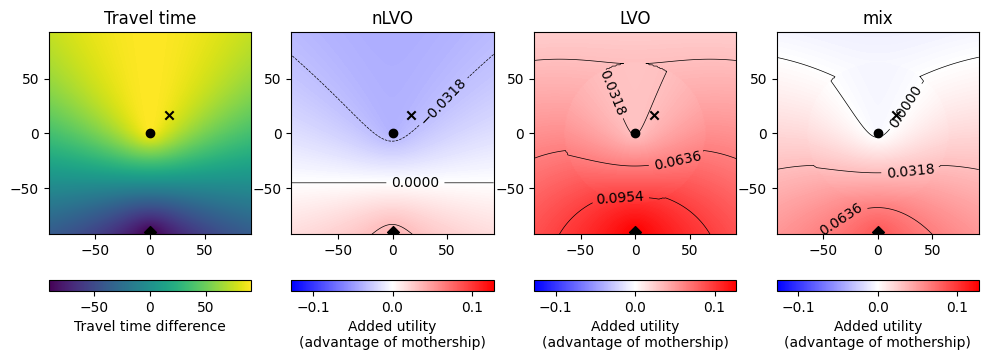

In [65]:
plot_geography_outliers(dict_grid_time_travel, dict_grid_time_travel_info, dict_outcomes_dicts, patient_x, patient_y)

### Utility matrix

In [51]:
matrix_mixed = pd.read_csv('../general_results/output/outcome_matrix_treated_ischaemic.csv')

In [52]:
matrix_mixed

,added_utility,mean_mrs,mrs_less_equal_2,mrs_shift,onset_to_needle_mins,onset_to_puncture_mins
0,0.204965,1.857484,0.641840,-1.108209,0.0,0.0
1,0.203045,1.869066,0.639726,-1.096627,10.0,0.0
2,0.201106,1.880724,0.637591,-1.084969,20.0,0.0
3,0.199148,1.892456,0.635435,-1.073237,30.0,0.0
4,0.197170,1.904261,0.633259,-1.061432,40.0,0.0
...,...,...,...,...,...,...
1857,0.007860,2.937686,0.430879,-0.028007,330.0,480.0
1858,0.004365,2.956387,0.427194,-0.009306,340.0,480.0
1859,0.000860,2.975102,0.423506,0.009409,350.0,480.0
1860,-0.002655,2.993831,0.419814,0.028138,360.0,480.0


In [53]:
n_times_ivt = len(set(matrix_mixed['onset_to_needle_mins']))
n_times_mt = len(set(matrix_mixed['onset_to_puncture_mins']))

grid_shape = (n_times_mt, n_times_ivt)

t_max_ivt = matrix_mixed['onset_to_needle_mins'].max()
t_max_mt = matrix_mixed['onset_to_puncture_mins'].max()

t_step_ivt = np.diff(matrix_mixed['onset_to_needle_mins'].values.reshape(grid_shape))[0][0]
t_step_mt = np.diff(matrix_mixed['onset_to_puncture_mins'].values.reshape(grid_shape))[0][0]

# Instead of the axes showing the row, column numbers of the grid,
# use this extent to scale the row, column numbers to the times.
# Extra division by 60 for conversion to hours.
grid_extent = np.array([
    - t_step_ivt * 0.5, t_max_ivt + t_step_ivt * 0.5,  # x-limits
    - t_step_mt * 0.5, t_max_mt + t_step_mt * 0.5     # y-limits
]) / 60.0

In [54]:
import matplotlib.ticker as ticker  # for axis tick locations

In [61]:
def plot_matrix_with_outliers(units_to_plot):
    fig, ax = plt.subplots()
    
    # Plot the matrix:
    c = ax.imshow(
        matrix_mixed['added_utility'].values.reshape(grid_shape),
        extent=grid_extent,
        origin='lower',
        cmap='plasma'
    )
    plt.colorbar(c, label='Added utility')
    # Contours:
    img1 = ax.contour(
        matrix_mixed['added_utility'].values.reshape(grid_shape),
        extent=grid_extent,
        levels=np.arange(0.0, 0.21, 0.01),
        colors='k',
        linewidths=0.5,
        # aspect=aspect,
    )
    ax.clabel(img1, inline=True, fontsize=10)

    for ivt_unit in units_to_plot:
        gdf_patients_normal = lsoa_data_gdf.loc[lsoa_data_gdf['closest_ivt_unit'] == ivt_unit]
        gdf_patients_outliers = gdf_out_adv.loc[gdf_out_adv['closest_ivt_unit'] == ivt_unit]
        mask = gdf_patients_normal.index.isin(gdf_patients_outliers.index.values)
        gdf_patients_normal = gdf_patients_normal.loc[~mask]
        # Scatter some patient timings:
        ax.scatter(
            [gdf_patients_normal['ivt_drip_ship'] / 60.0, gdf_patients_normal['ivt_mothership'] / 60.0],
            [gdf_patients_normal['mt_drip_ship'] / 60.0, gdf_patients_normal['mt_mothership'] / 60.0],
            marker='x',
            color='k',
            label=f'{ivt_unit} normal'
            # color='rgba(0, 0, 0, 0.2)'
        )
        ax.plot(
            [gdf_patients_normal['ivt_drip_ship'] / 60.0, gdf_patients_normal['ivt_mothership'] / 60.0],
            [gdf_patients_normal['mt_drip_ship'] / 60.0, gdf_patients_normal['mt_mothership'] / 60.0],
            color='k',
        )
        # Outliers:
        ax.scatter(
            [gdf_patients_outliers['ivt_drip_ship'] / 60.0, gdf_patients_outliers['ivt_mothership'] / 60.0],
            [gdf_patients_outliers['mt_drip_ship'] / 60.0, gdf_patients_outliers['mt_mothership'] / 60.0],
            marker='x',
            color='LimeGreen',
            label=f'{ivt_unit} outliers'
            # color='rgba(0, 0, 0, 0.2)'
        )
        ax.plot(
            [gdf_patients_outliers['ivt_drip_ship'] / 60.0, gdf_patients_outliers['ivt_mothership'] / 60.0],
            [gdf_patients_outliers['mt_drip_ship'] / 60.0, gdf_patients_outliers['mt_mothership'] / 60.0],
            color='LimeGreen',
        )
    
    ax.legend()
    
    ax.set_xlabel('Time to IVT (hours)\nif applicable')
    ax.set_ylabel('Time to MT (hours)\nif applicable')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
    
    plt.show()

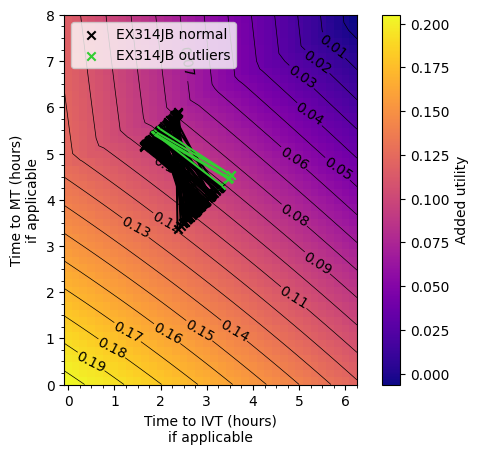

In [62]:
plot_matrix_with_outliers(['EX314JB'])

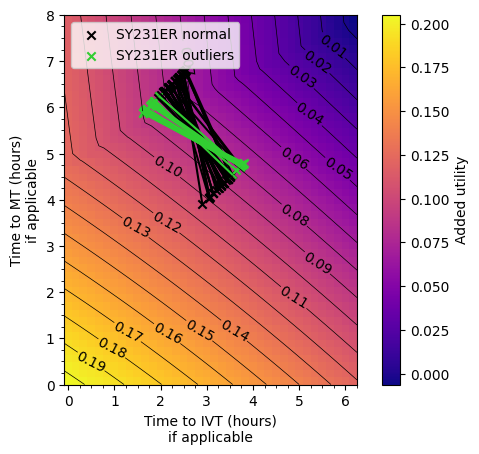

In [63]:
plot_matrix_with_outliers(['SY231ER'])

## Conclusion

The outlier areas are usually where there is a short travel time to the nearest stroke unit and a considerably longer time to the MT centre. The time difference is typically over 90 minutes.

The reason behind the worse outcomes is that the disbenefit from the increased time to IVT outweighs any additional benefit from decreasing time to MT.